In [3]:
#imports
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy as scpy
from scipy import stats
from scipy import ndimage
from skimage.transform import resize
import dionysus as d
import os
import csv
import pandas as pd
import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from statannot import add_stat_annotation

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import io

import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import *

# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages

import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42
matplotlib.rcParams['font.sans-serif']="Arial"
matplotlib.rcParams['font.family']="sans-serif"
# matplotlib.rcParams.update({'font.size': 12})

#### Load in images and determine user inputs

In [6]:
#load images
image_loc = '../../SH-CH/iPALM_podosome ring/'

file_name = image_loc
path, dirs, files = os.walk(file_name).__next__()
len_files = len(files)-1

files = [file for file in files if 'cropped' in file and 'figure' not in file]

In [5]:
# define pixel sizes
pix_sizes = np.array([*np.ones(3)*0.01, 0.009,*np.ones(3)*0.01])

pod_feature_size = 0.3 #um
site_feature_size = 1.5 #um


#### Run images through persistent homology pipeline to discover podosome and phagocytosis site locations
1. Perform persistent homology (see helper_functions.py) to find significant critical points within images.
2. Perform processing of the candidate significantly persistent features. For this step, several things are done (check out cluster_refine_pods_and_sites() in helper_functions.py). Essentially, make sure that we only keep podosomes associated with a well-defined site, that these sites have 3 or more podosomes, and that the site centers are centered based on their associated podosomes.

In [8]:
image_stacks = []
all_clusters = []
all_centers = []

for i,file in enumerate(files):
    image_stack = io.imread(image_loc+file,plugin="tifffile") #Image.open('002_AT_Act.tif')
    image_stacks.append([image_stack])
    image_mean = np.mean(image_stack,axis=0)

    pix_size = pix_sizes[i]
    len_micron = int(1/pix_size)
    pod_filt = int(pod_feature_size*len_micron)
    site_filt = int(site_feature_size*len_micron)

    pods, sites = find_pod_and_sites_ph(image_mean,pod_filt,site_filt,plot_bool=False,plot_pers=False,save_file = '')
    clusters,centers,radii = cluster_refine_pods_and_sites(pods,sites,image_mean,pix_size,plot_bool=False,save_file = '',upper_lim=2.5,lower_lim=1.5)
    all_clusters.append(clusters)
    all_centers.append(centers)

#### Save and/or load results. Visualize results.

In [12]:
### Save and/or Load results
# pickle.dump({'all_clusters':all_clusters,'all_centers':all_centers},open('iPALM_FoundLoc.pickled','wb'))

stored_results = pickle.load(open('iPALM_FoundLoc.pickled','rb'))
all_clusters = stored_results["all_clusters"]
all_centers = stored_results["all_centers"]

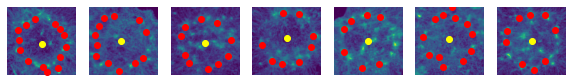

In [27]:
fig, axs = plt.subplots(1,7,figsize=(10,6))

for i in range(len(image_stacks)):
    x = i
    axs[x].imshow(np.mean(image_stacks[i],axis=1)[0])
    axs[x].scatter(all_clusters[i].T[0],all_clusters[i].T[1],color='red')
    axs[x].scatter(all_centers[i].T[0],all_centers[i].T[1],color='yellow')
    axs[x].axis('off')

#### Plot average of sites with 95% CI

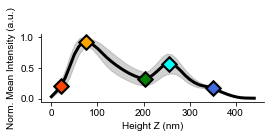

In [29]:
from scipy import signal

all_mean_at_heights = []
for i,image_stack in enumerate(image_stacks):
    mean_at_heights = []
    for image in image_stack[0]:
        mean_at_heights.append(np.mean(image))
    all_mean_at_heights.append(mean_at_heights)
all_mean_at_heights = np.array(all_mean_at_heights)

plt.figure(figsize=(4,1.25))
y = np.mean([max_min_scaled(p[:45]) for p in all_mean_at_heights] ,axis=0)
ci = 1.96*scpy.stats.sem([max_min_scaled(p[:45]) for p in all_mean_at_heights] ,axis=0)

x_nm = np.linspace(0,440,len(y))
finterp = scpy.interpolate.interp1d(x_nm,y,kind='cubic')
h_interp = np.linspace(0,np.max(x_nm),1000)
y_interp = finterp(h_interp)

peaks, _ = signal.find_peaks(y_interp,prominence = 0.2)
troughs, _ = signal.find_peaks(-y_interp,prominence = 0.2)

poi = np.sort(np.concatenate([peaks,troughs]))
other_poi = [2,35] #interested in low/high values

plt.plot(x_nm,y,lw=3,color='k')
plot_fill_between(plt,np.linspace(0,440,len(y)), y, ci, alpha=0.3,color='dimgray') 
    
plt.plot(h_interp[poi], y_interp[poi], "D",color='black',ms=11)
plt.plot(x_nm[other_poi], y[other_poi], "D",color='black',ms=11)
colors_match = ['orangered','orange','green','cyan','royalblue']
for zi in range(len(poi)):
    plt.plot(h_interp[poi[zi]], y_interp[poi[zi]], "D",color=colors_match[1:][zi],ms=7)

for zi in range(len(other_poi)):
    plt.plot(x_nm[other_poi[zi]], y[other_poi[zi]], "D",color=colors_match[::4][zi],ms=7)

plt.xlabel('Height Z (nm)')
plt.ylabel('Norm. Mean Intensity (a.u.)')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.tight_layout()

# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure2_iPALM_ROI+Methods/IndividualPlots/PhagoSiteZPlotwROI.pdf",transparent=True,dpi=300,bbox_inches='tight')
plt.show()

#### Perform radial averaging at each podosomes

In [33]:
min_stack_num = np.min([len(image[0]) for image in image_stacks])

z_height = 10 #nm
heights = np.arange(0,z_height*(min_stack_num),10)

all_rad_scans = []
all_x_ums = []

for i,image_stack in enumerate(image_stacks):
    rad_scans = []
    # plt.figure()
    for image in image_stack[0][:min_stack_num,:,:]:

        actin=image
        
        clusters = all_clusters[i]
        podosome_centers = np.array([list(point) for cluster in clusters for point in cluster])
        cxs = podosome_centers.T[0]
        cys = podosome_centers.T[1]
        
        pix_size = pix_sizes[i]

        rad_profs_act, x_ums = radial_averaging_from_pods(cxs,cys,actin,pix_size,1.1)

        rad_scans.append(rad_profs_act)
        
        
    all_rad_scans.append(rad_scans)
    all_x_ums.append(x_ums)
    

#### Process radial averaging scans
1. Want to have all of our data to use the same discretization
2. Interpolate any data with higher resolution to the the coarsest discretization
3. Also only keep from 0 to .6 micron

In [40]:
# Want to have all of our data to use the same discretization
# Interpolate any data that without the coarsest discretization to the coarsest
# Also only keep from 0 to .6 micron

max_r = 600#nm
for i, pix_size in enumerate(pix_sizes):
    x = all_x_ums[i]
    ys = all_rad_scans[i]
    fs = [scpy.interpolate.interp1d(x, y) for y in ys]

    xnew = np.arange(0,max_r/1000+0.01,0.01)
    ysnew = [f(xnew) for f in fs]
    all_x_ums[i] = xnew
    all_rad_scans[i] = ysnew

        

## Example of an individual podosome

In [207]:

# stack_all_rad_scans = np.hstack(all_rad_scans)

# average_radial = np.array(stack_all_rad_scans)[:,5,:] #5 best example
# # average_radial = scpy.ndimage.gaussian_filter(average_radial,1)
# average_radial = max_min_scaled(average_radial)

# # contour_level = 0.2
# # contour_thresh = contour_level*np.max(average_radial_mirrored)


# contour_level = np.mean(average_radial[:].T[:10])
# contour_thresh = contour_level #np.mean(average_radial_mirrored)*1.25


# x = np.linspace(0, max_r, len(average_radial_mirrored[0]))
# y = np.linspace(0, 10*(len(average_radial_mirrored)-1), len(average_radial_mirrored))
# X, Y = np.meshgrid(x, y)

# plt.figure()
# plt.imshow(average_radial_mirrored/np.max(average_radial_mirrored),extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.afmhot)
# plt.colorbar(fraction=0.025, pad=0.04)
# # CS = plt.contour(X,Y,average_radial_mirrored/np.max(average_radial_mirrored),levels=np.array([contour_level]), colors='limegreen', linestyles='--')

# plt.title('Single Podosome Actin Radial Averaging')
# plt.ylabel('Z (nm)')
# plt.xlabel('Distance R from Pod. Center (nm)')
# plt.tight_layout()

# # plt.savefig('SinglePod_iPALM_RadAvg.tif',dpi=150)

# plt.show()

# average_radial_zoomed = average_radial[:10]
# x = np.linspace(0, max_r, len(average_radial_zoomed[0]))
# y = np.linspace(0, 10*(len(average_radial_zoomed)-1), len(average_radial_zoomed))
# X, Y = np.meshgrid(x, y)

# plt.figure()
# plt.imshow(average_radial_zoomed,extent=[0,max_r,0,np.max(heights[:10])],aspect=6,origin='lower',interpolation='none',cmap=plt.cm.afmhot)
# plt.colorbar(fraction=0.025, pad=0.04)
# # plt.clim(0,1)
# # CS = plt.contour(X,Y,average_radial_mirrored_zoomed/np.max(average_radial_mirrored),levels=np.array([contour_level]), colors='limegreen', linestyles='--')

# plt.title('Single Podosome Actin Radial Averaging Zoom')
# plt.ylabel('Z (nm)')
# plt.xlabel('Distance R from Pod. Center (nm)')

# # plt.savefig('SinglePod_Zoom_iPALM_RadAvg.tif',dpi=150)

# plt.tight_layout()
# plt.show()


# # mean_central_actin = np.mean(average_radial_mirrored.T[len(average_radial_mirrored.T)//2:len(average_radial_mirrored.T)//2+11],axis=0)
# mean_central_actin = np.mean(average_radial_mirrored.T[:11],axis=0)
# finterp = scpy.interpolate.interp1d(heights,mean_central_actin,kind='cubic')
# h_interp = np.linspace(0,np.max(heights),max_r)
# y_interp = finterp(h_interp)

# zero_crossings = np.where(np.diff(np.sign(y_interp-contour_thresh)))[0]

# plt.figure()

# # for scan_r in average_radial_mirrored.T[len(average_radial_mirrored.T)//2:len(average_radial_mirrored.T)//2+11]:
# for scan_r in average_radial_mirrored.T[:11]:
#     plt.plot(heights,scan_r,'g--',alpha=0.5)
# plt.plot(h_interp,y_interp,c='k',lw=3)
# plt.xlabel('Z (nm)')
# plt.ylabel('Mean Actin Intensity Scaled (a.u.)')
# plt.title('Height Quantification')
# plt.hlines(contour_thresh,0,np.max(heights),color='lightblue')
# plt.hlines(contour_thresh,h_interp[np.min(zero_crossings)],h_interp[np.max(zero_crossings)],color='b')

# plt.tight_layout()
# # plt.savefig('SinglePod_iPALM_RadAvg_HeightQuant.tif',dpi=150)

# plt.show()

In [28]:
# all_rad_scans

## Plot each individual podosome's radial heatmap

In [1]:
# stack_all_rad_scans = np.hstack(all_rad_scans)


# for i in range(np.shape(stack_all_rad_scans)[1]):
#     average_radial = np.array(stack_all_rad_scans)[:,i,:] #np.mean(np.hstack(all_rad_scans),axis=1)
# #     average_radial = scpy.ndimage.gaussian_filter(average_radial_mirrored ,1)
#     average_radial = max_min_scaled(average_radial)

#     x = np.linspace(0, max_r, len(average_radial[0]))
#     y = np.linspace(0, 10*(len(average_radial)-1), len(average_radial))
#     X, Y = np.meshgrid(x, y)

#     plt.figure()
#     plt.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.afmhot)
#     plt.colorbar(fraction=0.025, pad=0.04)
# #     CS = plt.contour(X,Y,average_radial_mirrored/np.max(average_radial_mirrored),levels=np.array([contour_level]), colors='limegreen', linestyles='--')
#     plt.xlabel('R (nm)')
#     plt.ylabel('Height Z (nm)')
#     plt.title('Pod. # %i' %i)

In [3]:
pods = [0,10,22,48,50,66]

for i in pods:
    average_radial = np.array(stack_all_rad_scans)[:,i,:] #np.mean(np.hstack(all_rad_scans),axis=1)
#     average_radial = scpy.ndimage.gaussian_filter(average_radial_mirrored ,1)
    average_radial = max_min_scaled(average_radial)
    
    plt.figure()
    plt.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.afmhot)
    plt.colorbar(fraction=0.025, pad=0.04)
    
#     pickle.dump(average_radial, open('Pod%iRadAvgHM.p'%i,'wb'))

#### Plot all radial heatmaps (excluding those used in main figures), and plot zoomed heatmaps (to focus on protrusion)

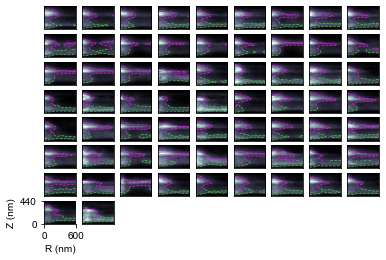

In [45]:
stack_all_rad_scans = np.hstack(all_rad_scans)
# stack_all_rad_scans = np.hstack(all_rad_scans_same_height)

plt.figure(figsize=(6,4))

pods_main = [0,2,10,22,48,50,66]
skipped_count = 0

for i in range(np.shape(stack_all_rad_scans)[1]):
    
    if i in pods_main:
        skipped_count += 1
        continue
    
    average_radial = np.array(stack_all_rad_scans)[:,i,:] 
    average_radial = max_min_scaled(average_radial)
    
    # Used for the contour
    average_radial_smoothed = max_min_scaled(scpy.ndimage.gaussian_filter(average_radial ,1))

    # Get contour threshold 
    # Value used is the mean intensity within 350 nm radius
    contour_level = np.mean(average_radial_smoothed[:].T[:36]) 

    x = np.linspace(0, max_r, len(average_radial[0]))
    y = np.linspace(150, 10*(len(average_radial)-1), len(average_radial[16:]))
    X, Y = np.meshgrid(x, y)

    plt.subplot(8,9,i+1-skipped_count)
    if i+1-skipped_count != 64:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.ylabel('Z (nm)')
        plt.xlabel('R (nm)')
        plt.xticks([0,600])
        plt.yticks([0,10*(len(average_radial)-1)])
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    im = plt.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.bone)
    CS = plt.contour(X,Y,average_radial_smoothed[16:],levels=np.array([contour_level]), colors='magenta', linestyles='--')
    plt.setp(CS.collections , linewidth=0.75)
    
    average_radial_zoomed = average_radial_smoothed[:16] #scpy.ndimage.gaussian_filter(average_radial_mirrored[:15],1)
    average_radial_zoomed_smoothed = average_radial_smoothed[:16]
    x = np.linspace(0, max_r, len(average_radial_zoomed[0]))
    y = np.linspace(0, 10*(len(average_radial_zoomed)-1), len(average_radial_zoomed))
    X, Y = np.meshgrid(x, y)

    CS = plt.contour(X,Y,average_radial_zoomed_smoothed,levels=np.array([contour_level]), colors='limegreen', linestyles='--',linewidth=0.5)
    plt.setp(CS.collections , linewidth=0.75)

    

# plt.tight_layout()
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/AllRadHM_MinusMainPlots.pdf",transparent=True,dpi=300)


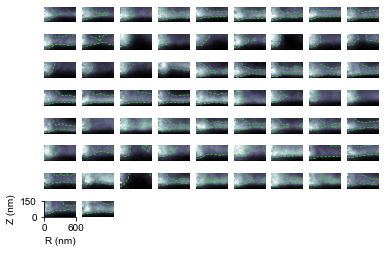

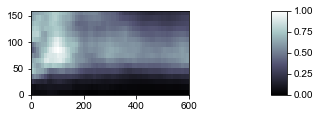

In [47]:
stack_all_rad_scans = np.hstack(all_rad_scans)

plt.figure(figsize=(6,4))

pods_main = [0,2,10,22,48,50,66]
skipped_count = 0

for i in range(np.shape(stack_all_rad_scans)[1]):
    
    if i in pods_main:
        skipped_count += 1
        continue
        
    average_radial = np.array(stack_all_rad_scans)[:,i,:] 
    average_radial = max_min_scaled(average_radial)
    
    # Used for the contour
    average_radial_smoothed = max_min_scaled(scpy.ndimage.gaussian_filter(average_radial ,1))

    # Get contour threshold 
    # Value used is the mean intensity within 350 nm radius
    contour_level = np.mean(average_radial_smoothed[:].T[:36]) 
    
    # Zoom in an observe contour below 150 nm Z
    average_radial_zoomed = average_radial[:16] #scpy.ndimage.gaussian_filter(average_radial_mirrored[:15],1)
    average_radial_zoomed_smoothed = average_radial_smoothed[:16]
    x = np.linspace(0, max_r, len(average_radial_zoomed[0]))
    y = np.linspace(0, 10*(len(average_radial_zoomed)-1), len(average_radial_zoomed))
    X, Y = np.meshgrid(x, y)

    
    plt.subplot(8,9,i+1-skipped_count)
    if i+1-skipped_count != 64:
        plt.axis('off')
    else:
        plt.ylabel('Z (nm)')
        plt.xlabel('R (nm)')
        plt.xticks([0,600])
        plt.yticks([0,150])
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.imshow(average_radial_zoomed,extent=[0,max_r,0,10*(len(average_radial_zoomed)-1)],aspect=2,origin='lower',interpolation='none',cmap=plt.cm.bone)
    CS = plt.contour(X,Y,average_radial_zoomed_smoothed,levels=np.array([contour_level]), colors='limegreen', linestyles='--',linewidth=0.5)
    plt.setp(CS.collections , linewidth=0.75)
        
plt.figure()
plt.imshow(average_radial_zoomed,extent=[0,max_r,0,10*len(average_radial_zoomed)],aspect=2,origin='lower',interpolation='none',cmap=plt.cm.bone)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/BoneHM_ColorBar.pdf",transparent=True,dpi=300)



In [668]:
# pickle.dump(average_radial,open('RadialAveragingPodosome0to600nm.p','wb'))

In [15]:
# pickle.dump( average_radial, open( "meanRadPod.p", "wb" ) )

#### Plot average within 100 nm and beyond 400 nm distributions

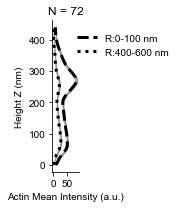

In [49]:
all_rad = np.hstack(all_rad_scans)

plt.figure(figsize=(2,3))
mean_within100 = np.mean(np.mean(all_rad.T[:11],axis=0),axis=0)
ci_within100 = 1.96*stats.sem(np.mean(all_rad.T[:11],axis=0),axis=0)
plt.plot(mean_within100,heights,'--',c='k',lw=3)
plt.fill_betweenx(heights, (mean_within100-ci_within100), \
                 (mean_within100+ci_within100), \
                 alpha=0.3,color='k') 


mean_out400 = np.mean(np.mean(all_rad.T[40:],axis=0),axis=0)
ci_out400 = 1.96*stats.sem(np.mean(all_rad.T[40:],axis=0),axis=0)
plt.plot(mean_out400,heights,':',c='k',lw=3)
plt.fill_betweenx(heights, (mean_out400-ci_out400), \
                 (mean_out400+ci_out400), \
                 alpha=0.3,color='k') 


plt.ylabel('Height Z (nm)')
plt.xlabel('Actin Mean Intensity (a.u.)')
plt.legend(['R:0-100 nm','R:400-600 nm'],bbox_to_anchor = [0.59, 0.7],frameon=False)
plt.title('N = %i' %(np.shape(all_rad)[1]))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.tight_layout()
# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure4_PodosomeQuantifications/IndividualPlots/WithinOutsideIntensity.pdf",transparent=True,dpi=300,bbox_inches='tight')


In [34]:
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


In [35]:
# def out_in_stack(in_dist, out_dist):
#     return([np.hstack([in_dist[i][:1:-1],out_dist[i]]) for i in range(len(in_dist))])

# def out_in_1d(in_dist, out_dist):
#     return(np.hstack([in_dist[::-1],out_dist[1:]]))

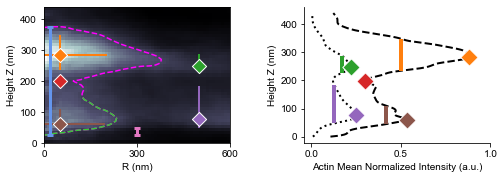

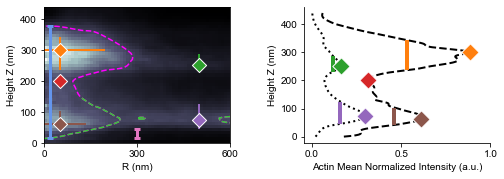

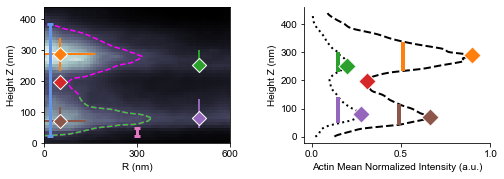

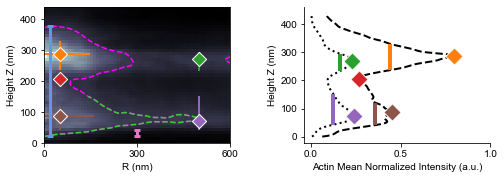

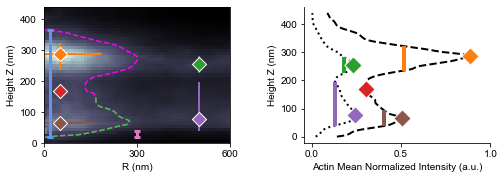

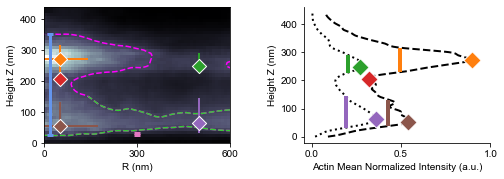

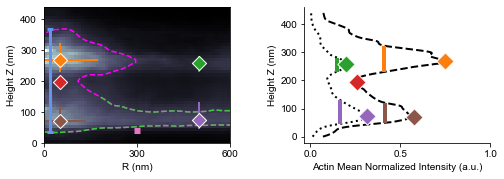

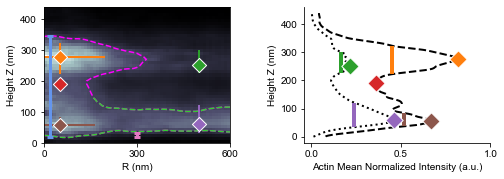

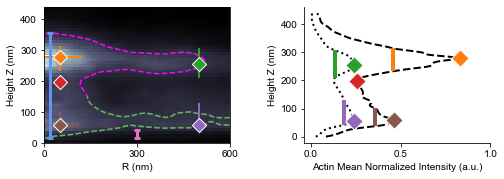

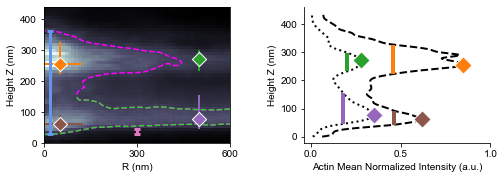

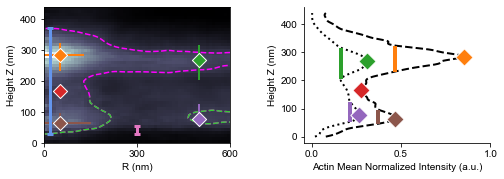

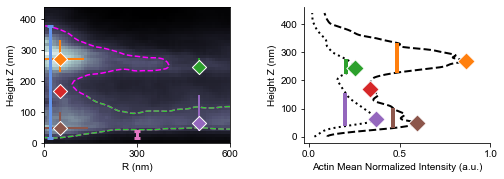

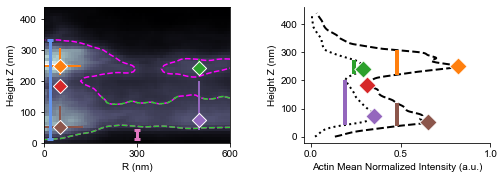

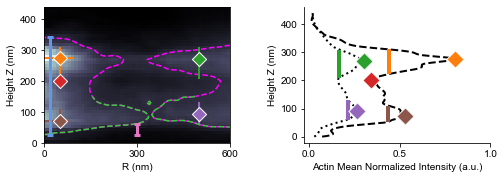

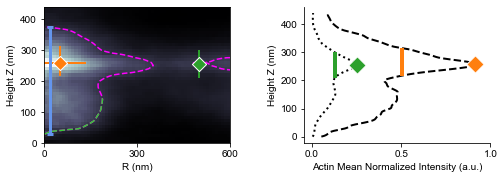

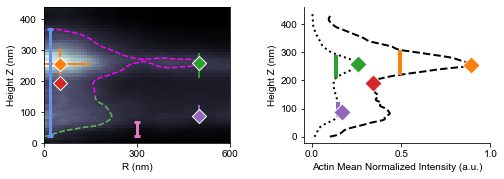

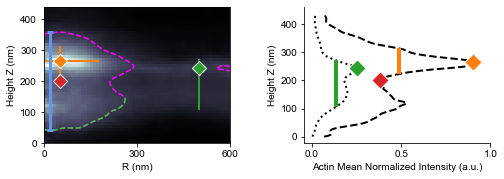

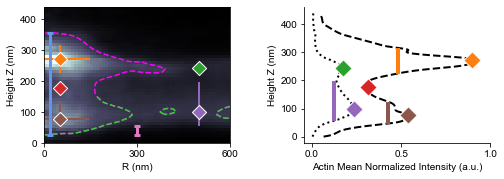

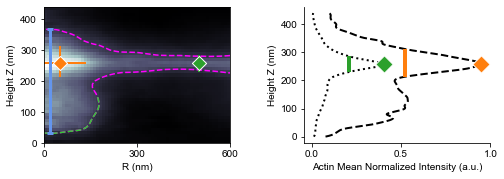

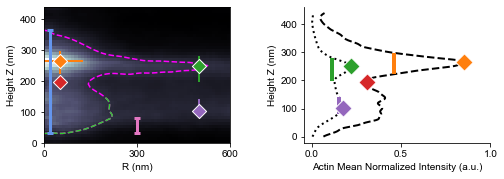

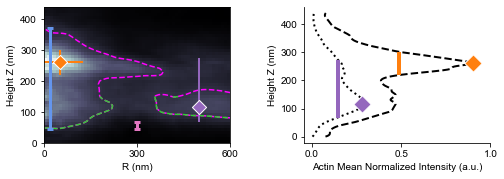

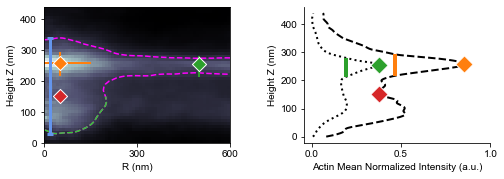

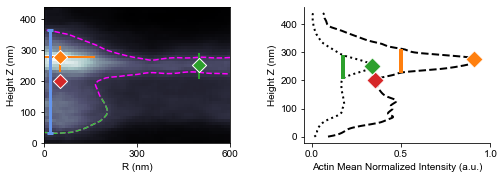

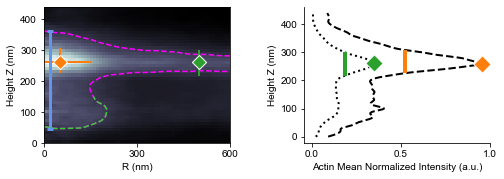

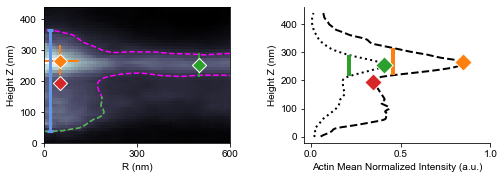

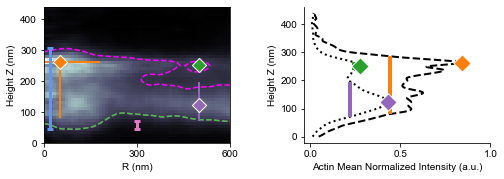

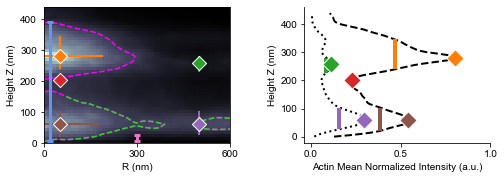

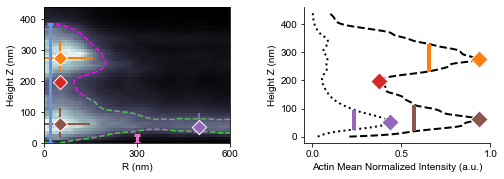

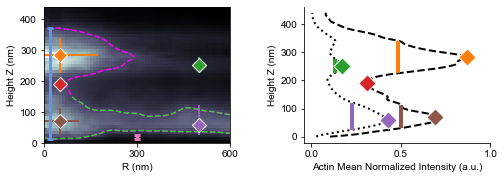

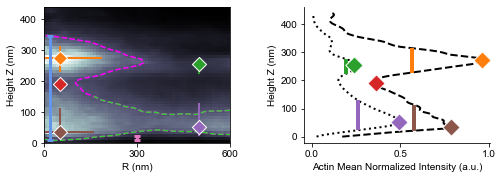

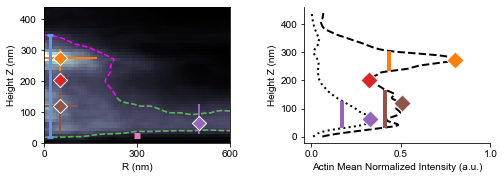

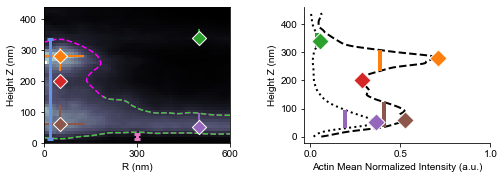

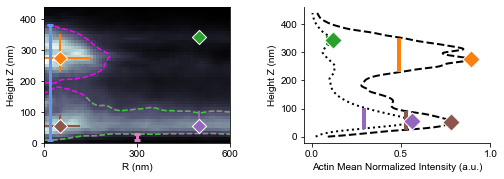

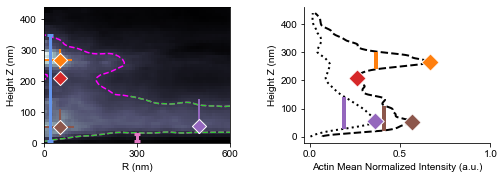

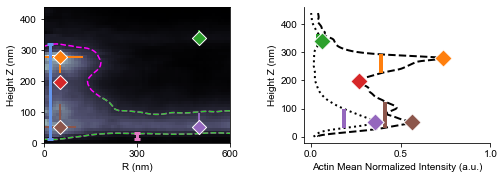

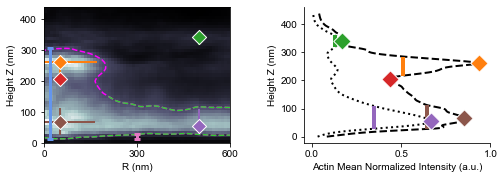

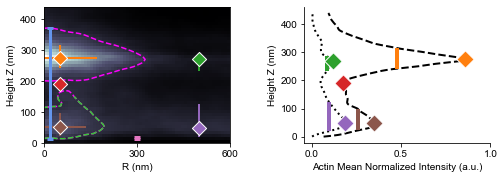

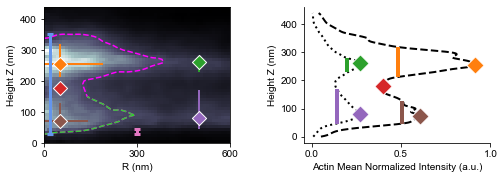

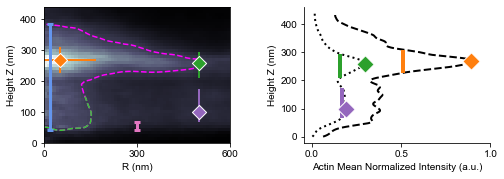

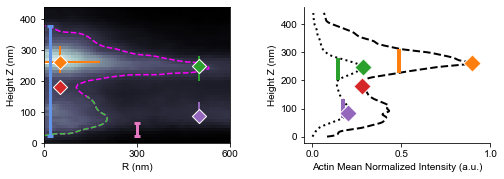

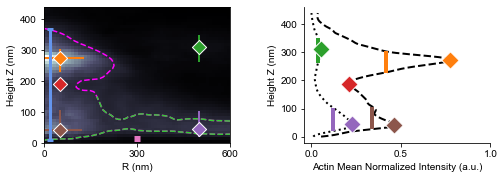

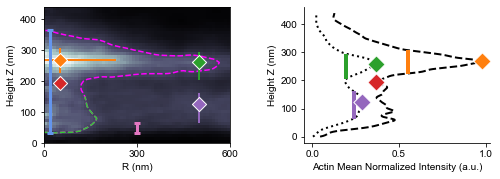

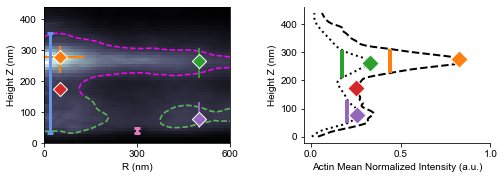

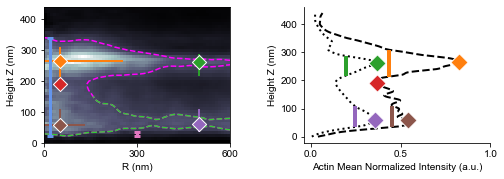

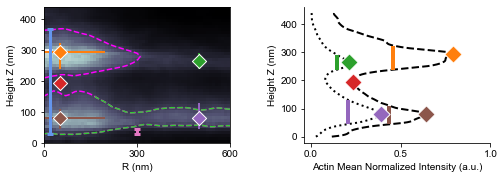

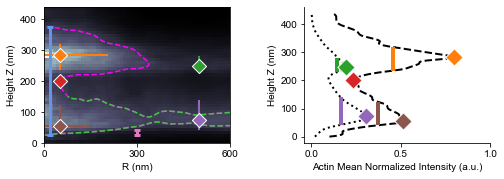

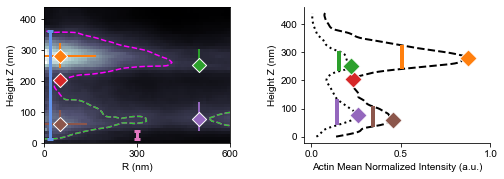

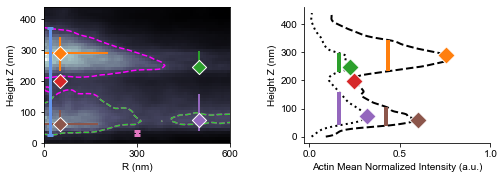

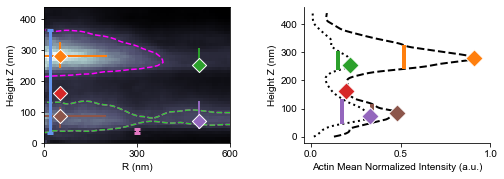

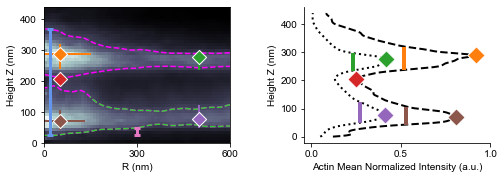

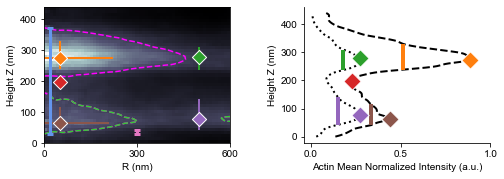

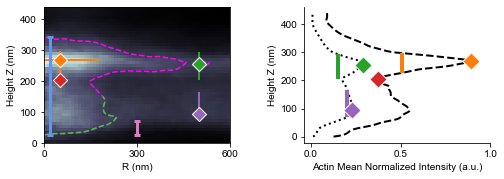

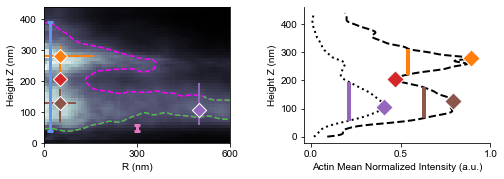

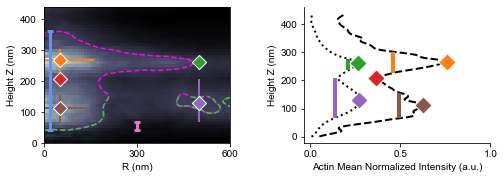

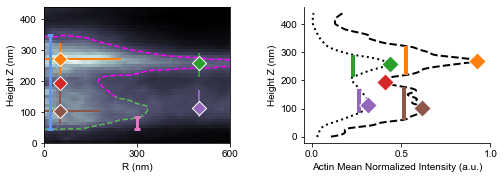

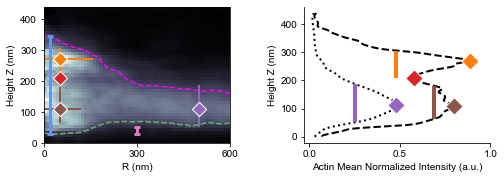

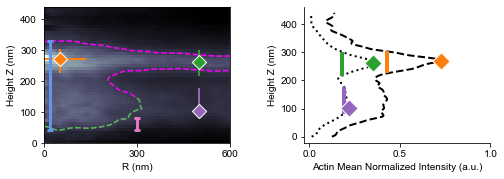

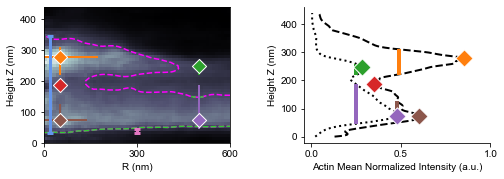

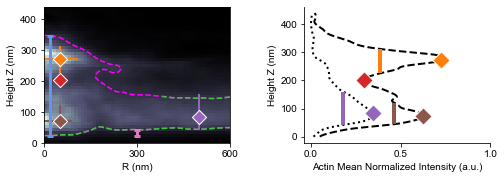

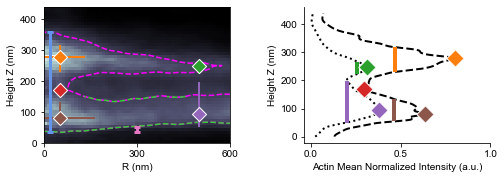

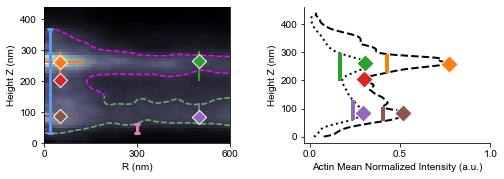

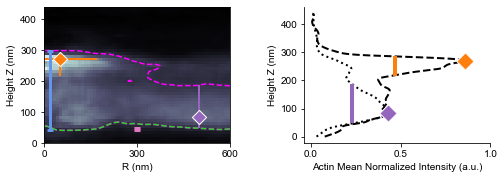

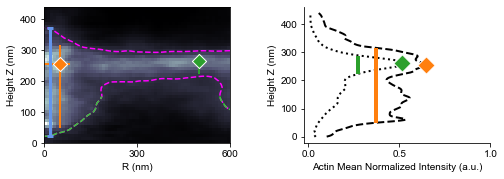

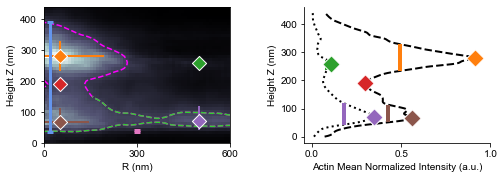

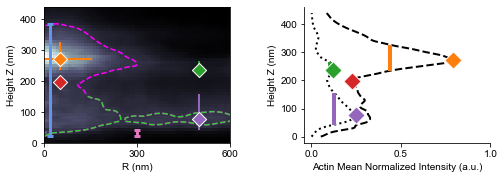

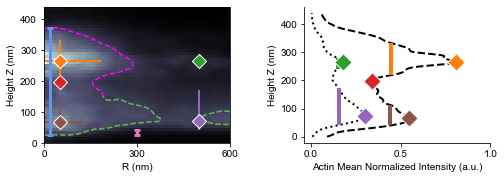

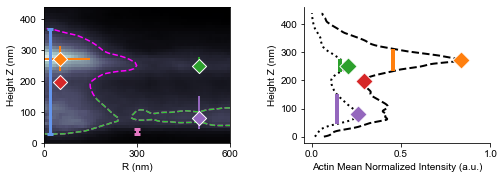

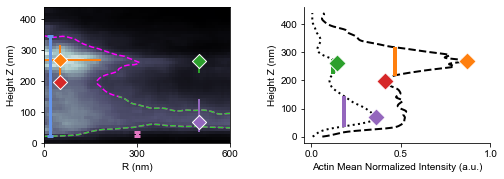

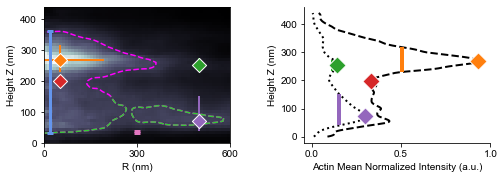

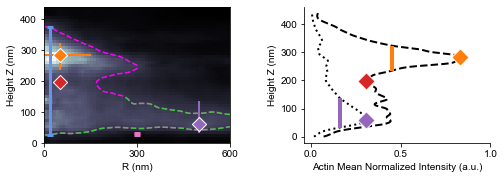

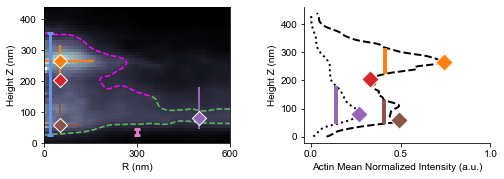

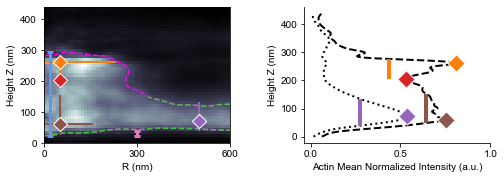

In [79]:
stack_all_rad_scans = np.hstack(all_rad_scans)
from scipy.signal import find_peaks, peak_widths

pod_height = []
protrusion_below_net = []

two_peaks_pod = []
one_peak_pod = []
all_troughs = []

fwhm_upper_core = []
radii_fwhm_upper_core = []
fwhm_lower_core = []
radii_fwhm_lower_core = []

two_peaks_net = []
one_peak_net = []
peaks_net = []

fwhm_upper_net = []
fwhm_lower_net = []

colors = sns.color_palette() #"hls", 7)
colors[0] = 'cornflowerblue'

pods_main = [0,2,10,22,48,50,66]

for pod_i in range(np.shape(stack_all_rad_scans)[1]):
    f, (ax_hm, ax_peak) = plt.subplots(1,2,gridspec_kw={'width_ratios': [.5,.5]},figsize=(8.,2.5))
    ## for supplement
#     f, (ax_hm, ax_peak) = plt.subplots(1,2,gridspec_kw={'width_ratios': [.5,.5]},figsize=(6.,1.5))
#     matplotlib.rcParams.update({'font.size': 12})
    
    average_radial = np.array(stack_all_rad_scans)[:,pod_i,:] 
    average_radial = max_min_scaled(average_radial)

    
    average_radial_smoothed = max_min_scaled(scpy.ndimage.gaussian_filter(average_radial ,1))

    # Get contour threshold 
    # Value used is the mean intensity within 350 nm radius
    contour_level = np.mean(average_radial_smoothed[:].T[:36]) 


    # Get meshgrid for contour
    x = np.linspace(0, max_r, len(average_radial[0]))
    y = np.linspace(0, 10*(len(average_radial)-1), len(average_radial))
    X, Y = np.meshgrid(x, y)

    im = ax_hm.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.bone)
    CS = ax_hm.contour(X,Y,average_radial_smoothed,levels=np.array([contour_level]), colors='magenta', linestyles='--',linewidth=0.5,zorder=1)
    
    # Get contour segments
    segs = CS.allsegs[0]
    seg_min_y = [np.min(seg.T[1]) if len(seg.T[1]) > 30 else 10e5 for seg in segs]
    seg_max_y = [np.max(seg.T[1]) if len(seg.T[1]) > 30 else 0 for seg in segs]
    
    # Podosome height is the difference between max and min y values of the contour
    pod_height.append(np.max(seg_max_y)-np.min(seg_min_y))

    x_loc = 20
    ax_hm.vlines(x_loc,np.max(seg_max_y),np.min(seg_min_y),color=colors[0],lw=3,zorder=9)
    ax_hm.hlines(np.max(seg_max_y),x_loc-10,x_loc+10,color=colors[0],lw=3,zorder=9)
    ax_hm.hlines(np.min(seg_min_y),x_loc-10,x_loc+10,color=colors[0],lw=3,zorder=9)

    ax_hm.set_yticks([0,100,200,300,400])
    ax_hm.set_ylabel('Height Z (nm)') #''Height Z (nm) ')
    ax_hm.set_xlabel('R (nm)')

    
    # Zoom in an observe contour below 100 nm Z
    average_radial_zoomed = average_radial[:16] #scpy.ndimage.gaussian_filter(average_radial_mirrored[:15],1)
    average_radial_zoomed_smoothed = average_radial_smoothed[:16]
    x = np.linspace(0, max_r, len(average_radial_zoomed[0]))
    y = np.linspace(0, 10*(len(average_radial_zoomed)-1), len(average_radial_zoomed))
    X, Y = np.meshgrid(x, y)

    CS = ax_hm.contour(X,Y,average_radial_zoomed_smoothed,levels=np.array([contour_level]), colors='limegreen', linestyles='--',linewidth=0.5,zorder=2)

    #get quantifications within 100 nm (podosome quantifications)
    average_radial_within = np.mean(average_radial.T[:11],axis=0)
    finterp = scpy.interpolate.interp1d(heights,average_radial_within,kind='cubic')
    h_interp = np.linspace(0,np.max(heights),1000)
    y_interp = finterp(h_interp)
    
    ax_peak.plot(y_interp,h_interp,'--',lw=2,zorder=-1,c='k')
#     plt.title('Mean Actin At R<=100 nm')
    ax_peak.set_ylabel('Height Z (nm)')
    ax_peak.set_xlabel('Actin Mean Normalized Intensity (a.u.)')
    
    peaks, _ = find_peaks(y_interp,prominence = 0.2*np.max(y_interp))
    results_half = np.array(peak_widths(y_interp, peaks, rel_height=0.5))
#     plt.scatter(y_interp[peaks],h_interp[peaks],50,marker='x',color='r')

    for peak in peaks:
        if h_interp[peak] < 200:
            ax_peak.scatter(y_interp[peak],h_interp[peak],150,marker='D',color=colors[5],zorder=10,edgecolor='w')
            ax_hm.scatter(50,h_interp[peak],100,marker='D',color=colors[5],zorder=10,edgecolor='w')
            
        else:
            ax_peak.scatter(y_interp[peak],h_interp[peak],150,marker='D',color=colors[1],zorder=10,edgecolor='w')
            ax_hm.scatter(50,h_interp[peak],100,marker='D',color=colors[1],zorder=10,edgecolor='w')
    
    fwhm_hs = results_half[1]
    fwhm_lhs = h_interp[[np.int(val) for val in results_half[2]]]
    fwhm_rhs = h_interp[[np.int(val) for val in results_half[3]]]
    
    trough = []
    troughs, _ = find_peaks(-y_interp,prominence = 0.1*np.max(y_interp))
    
    if len(troughs) ==1:
        all_troughs.append(h_interp[troughs])
        ax_peak.scatter(y_interp[troughs],h_interp[troughs],150,marker='D',color=colors[3],zorder=10,edgecolor='w')
        ax_hm.scatter(50,h_interp[troughs],100,marker='D',color=colors[3],zorder=10,edgecolor='w')
      
        trough = h_interp[troughs[0]]

            
    #get vertical FWHM quantifications for the podosome
    #adjusts fwhm so that it doesn't pass a prominent minima (and go into another peak)
    for j in range(len(fwhm_hs)):
        lhs,rhs = fwhm_lhs[j],fwhm_rhs[j]
        peak_loc = h_interp[int(peaks[j])]
        
        if peak_loc < 175:
            if trough:
                if rhs > trough:
                    rhs = trough
            fwhm = rhs-lhs
            fwhm_lower_core.append(fwhm)
            ax_peak.vlines(fwhm_hs[j],lhs,rhs, color=colors[5],lw=4)
            ax_hm.vlines(50,lhs,rhs, color=colors[5],lw=2)
            
             # get FWHM/2 (=Radius) for lower core
            lc_arr = np.mean(average_radial[int(lhs/10):int(rhs/10)],axis=0)
            rs = np.linspace(-max_r, max_r, 2*len(average_radial[0])-1)
            mirror_wnoise = out_in_1d(lc_arr,lc_arr) + np.random.rand(len(rs))*10e-5
            finterp_lc = scpy.interpolate.interp1d(rs,mirror_wnoise,kind='cubic')
            r_interp_lc = np.linspace(-max_r,max_r,1001)
            y_interp_lc = finterp_lc(r_interp_lc)
            peaks_lc, _ = find_peaks(y_interp_lc,prominence = 0.2*np.max(y_interp_lc))
            if np.shape(peaks_lc)[0] >1:
                peaks_lc = [peaks_lc[0]]

            results_half_lc = np.array(peak_widths(y_interp_lc, peaks_lc, rel_height=0.5))

            fwhm_lc_rhs = np.abs(r_interp_lc[[np.int(val) for val in results_half_lc[3]]])

            ax_hm.hlines(peak_loc,0,fwhm_lc_rhs, color=colors[5],lw=2)

            radii_fwhm_lower_core.append(fwhm_lc_rhs[0])
            
            
        else:
            if trough:
                if lhs < trough:
                    lhs = trough
            fwhm = rhs-lhs
            fwhm_upper_core.append(fwhm)
            ax_peak.vlines(fwhm_hs[j],lhs,rhs ,color=colors[1],lw=4)
            ax_hm.vlines(50,lhs,rhs, color=colors[1],lw=2)

            # get FWHM/2 (=Radius) for lower core
            uc_arr = np.mean(average_radial[int(lhs/10):int(rhs/10)],axis=0)
            rs = np.linspace(-max_r, max_r, 2*len(average_radial[0])-1)
            #out_in_1d reflects the scan - makes the peak/FWHM finding easier
            mirror_wnoise = out_in_1d(uc_arr,uc_arr) + np.random.rand(len(rs))*10e-5
            finterp_uc = scpy.interpolate.interp1d(rs,mirror_wnoise,kind='cubic')
            r_interp_uc = np.linspace(-max_r,max_r,1001)
            y_interp_uc = finterp_uc(r_interp_uc)
            peaks_uc, _ = find_peaks(y_interp_uc,prominence = 0.2*np.max(y_interp_uc))
            if np.shape(peaks_uc)[0] >1:
                peaks_uc = [peaks_uc[0]]
            results_half_uc = np.array(peak_widths(y_interp_uc, peaks_uc, rel_height=0.5))
            fwhm_uc_rhs = np.abs(r_interp_uc[[np.int(val) for val in results_half_uc[3]]])
            ax_hm.hlines(peak_loc,0,fwhm_uc_rhs, color=colors[1],lw=2)
            radii_fwhm_upper_core.append(fwhm_uc_rhs[0])

    if(len(peaks)==1):
        one_peak_pod.append(h_interp[peaks])
        
    elif(len(peaks)==2):
        two_peaks_pod.append(h_interp[peaks])
        
    peaks_net.append(h_interp[peaks])

    #get quantifications for beyond 400 nm (upper and lower actin network)  
    average_radial_beyond = np.mean(average_radial.T[len(average_radial.T)*2//3:],axis=0)
    finterp = scpy.interpolate.interp1d(heights,average_radial_beyond,kind='cubic')
    h_interp = np.linspace(0,np.max(heights),max_r)
    y_interp = finterp(h_interp)
    
    ax_peak.plot(y_interp,h_interp,':',lw=2,zorder=-1,c='k')
    
    peaks, _ = find_peaks(y_interp,prominence = 0.1*np.max(y_interp))
    results_half = np.array(peak_widths(y_interp, peaks, rel_height=0.5))
#     plt.scatter(y_interp[peaks],h_interp[peaks],50,marker='x',color='r')
    
    for peak in peaks:
        if h_interp[peak] < 175:
            ax_peak.scatter(y_interp[peak],h_interp[peak],150,marker='D',color=colors[4],zorder=10,edgecolor='w')
            ax_hm.scatter(500,h_interp[peak],100,marker='D',color=colors[4],zorder=10,edgecolor='w')
        else:
            ax_peak.scatter(y_interp[peak],h_interp[peak],150,marker='D',color=colors[2],zorder=10,edgecolor='w')
            ax_hm.scatter(500,h_interp[peak],100,marker='D',color=colors[2],zorder=10,edgecolor='w')
            
    minima, _ = find_peaks(-y_interp,prominence = 0.1*np.max(y_interp))
    
#     find actual minima value
    if minima:
        minima = h_interp[minima[0]]
            
    fwhm_hs = results_half[1]
    fwhm_lhs = h_interp[[np.int(val) for val in results_half[2]]]
    fwhm_rhs = h_interp[[np.int(val) for val in results_half[3]]]
    

    #get vertical FWHM quantifications for the actin network values
    #adjusts fwhm so that it doesn't pass a prominent minima (and go into another peak)
    for j in range(len(fwhm_hs)):
        lhs,rhs = fwhm_lhs[j],fwhm_rhs[j]
        peak_loc = h_interp[int(peaks[j])]
        
        if peak_loc < 175:
            if minima:
                if rhs > minima:
                    rhs = minima
            fwhm = rhs-lhs
            fwhm_lower_net.append(fwhm)

            protrusion_below_net.append(lhs-np.min(seg_min_y))
            
            ax_hm.vlines(300,lhs,np.min(seg_min_y),color=colors[6],lw=3,zorder=9)
            ax_hm.hlines(lhs,300-10,300+10,color=colors[6],lw=3,zorder=9)
            ax_hm.hlines(np.min(seg_min_y),300-10,300+10,color=colors[6],lw=3,zorder=9)
            
            ax_peak.vlines(fwhm_hs[j],lhs,rhs, color=colors[4],lw=4)
            ax_hm.vlines(500,lhs,rhs, color=colors[4],lw=2)  
        else:
            if minima:
                if lhs < minima:
                    lhs = minima
            fwhm = rhs-lhs
            fwhm_upper_net.append(fwhm)
            ax_peak.vlines(fwhm_hs[j],lhs,rhs ,color=colors[2],lw=4)
            ax_hm.vlines(500,lhs,rhs, color=colors[2],lw=2)

    
    if(len(peaks)==1):
        one_peak_net.append(h_interp[peaks])
        
    elif(len(peaks)==2):
        two_peaks_net.append(h_interp[peaks])
        
    custom_lines = [Line2D([0], [0], color='k', lw=2,ls='--'),
                Line2D([0], [0], color='k', lw=2,ls=':')]

    ax=plt.gca()
    ax_peak.spines['right'].set_visible(False)
    ax_peak.spines['top'].set_visible(False)
#     ax_peak.legend(custom_lines, ['Within 100 nm',  'Outside 400 nm'])#,bbox_to_anchor=(1.1, 1.1))
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.35)


    ax_hm.set_xticks([0,300,600])
    ax_hm.set_yticks([0,100,200,300,400])
    
    ax_peak.set_xticks([0,0.5,1])
    ax_peak.set_yticks([0,100,200,300,400])
    
    
    plt.subplots_adjust(wspace=0.4)
    ax_hm.set_aspect('auto')
    
#     if pod_i in pods_main or pod_i==2:
#         plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure5_PodosomeQuantifications/IndividualPlots/IndQuantPeakFWHMPod%i.pdf"%pod_i,transparent=True,dpi=300,bbox_inches='tight')


plt.show()

peak_dat_l100 = np.hstack([np.hstack(two_peaks_pod),np.hstack(one_peak_pod)])
peak_dat_g400 = np.hstack([np.hstack(two_peaks_net),np.hstack(one_peak_net)])


#### Plot and report quantifications

In [82]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [85]:
colors = sns.color_palette()

# colors = colors[1:2] + colors[4:]
colors = colors[1:]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Upper Core v.s. Upper Network: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.911e-09 U_stat=3.536e+03
Lower Network v.s. Lower Core: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.505e-03 U_stat=2.056e+03


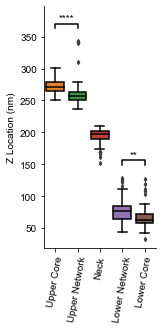

In [87]:
colors = sns.color_palette()
colors = colors[1:]

upper_network = peak_dat_g400[peak_dat_g400> 175]
lower_network = peak_dat_g400[peak_dat_g400< 175]

upper_core = peak_dat_l100[peak_dat_l100> 175]
neck = np.array(all_troughs).flatten()
lower_core = peak_dat_l100[peak_dat_l100< 175]

quant = np.hstack([upper_core,upper_network,neck,lower_network,lower_core])
meas = np.hstack([['Upper Core']*len(upper_core),['Upper Network']*len(upper_network),
                  ['Neck']*len(neck),['Lower Network']*len(lower_network),
                  ['Lower Core']*len(lower_core)])

quant_df = pd.DataFrame(list(zip(quant,meas)),columns = ['Quantification','Measure'])

df = quant_df
x = 'Measure'
y = 'Quantification'
box_pairs=[
    ("Upper Core", "Upper Network"),
    ("Lower Core", "Lower Network"),
    ]

fig = plt.figure(figsize=(2.,4.45))

flierprops = dict(marker='d', markersize=3)

ax = sns.boxplot(x=x, y=y,data=df,showfliers=True,palette=colors,flierprops=flierprops)
# sns.stripplot(x=x, y=y,  data=df,color=".2",alpha=0.5)
add_stat_annotation(ax, data=df, x=x, y=y, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)


ax = plt.gca()
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    # iterate over whiskers and median lines
    for j in range(6*5+2): #range(6*i,6*(i+1)):
        ax.lines[j].set_color('black')
        
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

            
plt.xlabel('')
plt.xticks(rotation=80)
plt.ylabel('Z Location (nm)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


adjust_box_widths(fig, 0.98)

# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure4_PodosomeQuantifications/IndividualPlots/IndQuantLoc.pdf",transparent=True,dpi=300,bbox_inches='tight')


# plt.tight_layout()

In [89]:
for meas in quant_df['Measure'].unique():
    print(meas, sum(quant_df['Measure']==meas))

Upper Core 72
Upper Network 61
Neck 61
Lower Network 64
Lower Core 48


In [92]:
for meas in quant_df['Measure'].unique():
    print(meas, quant_df[quant_df['Measure']==meas].mean(),quant_df[quant_df['Measure']==meas].std())

Upper Core Quantification    272.345123
dtype: float64 Quantification    10.307838
dtype: float64
Upper Network Quantification    263.043871
dtype: float64 Quantification    23.633548
dtype: float64
Neck Quantification    193.750472
dtype: float64 Quantification    12.424716
dtype: float64
Lower Network Quantification    77.805718
dtype: float64 Quantification    19.420594
dtype: float64
Lower Core Quantification    68.653654
dtype: float64 Quantification    19.155658
dtype: float64


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Upper Core v.s. Lower Core: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.662e-03 U_stat=2.316e+03


(array([  0, 100, 200, 300]),
 [Text(1, 50.0, '50'),
  Text(1, 100.0, '100'),
  Text(1, 150.0, '150'),
  Text(1, 200.0, '200')])

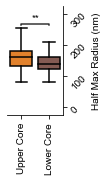

In [93]:
colors = sns.color_palette()
colors = colors[1:6:4]

radii = np.hstack([radii_fwhm_upper_core,radii_fwhm_lower_core])
core = np.hstack([['Upper Core']*len(radii_fwhm_upper_core),['Lower Core']*len(radii_fwhm_lower_core)])

rad_df = pd.DataFrame(list(zip(radii,core)),columns = ['Radius','Core'])

df = rad_df
x = 'Core'
y = 'Radius'
box_pairs=[
    ("Upper Core", "Lower Core"),
    ]

fig = plt.figure(figsize=(1.,2.))

ax = sns.boxplot(x=x, y=y,data=df,showfliers=True,palette=colors)
# sns.stripplot(x=x, y=y,  data=df,color=".2",alpha=0.5)
add_stat_annotation(ax, data=df, x=x, y=y, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)


ax = plt.gca()
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    # iterate over whiskers and median lines
    for j in range(11): #range(6*i,6*(i+1)):
        ax.lines[j].set_color('black')
        
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

            
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel('Half Max Radius (nm)')

adjust_box_widths(fig, 0.98)

plt.ylim([-25,325])

plt.yticks([0,100,200,300])


ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.yticks(rotation = 45)



# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure4_PodosomeQuantifications/IndividualPlots/IndQuantCoreRadii.pdf",transparent=True,dpi=300,bbox_inches='tight')


# plt.tight_layout()

In [181]:
for meas in rad_df['Core'].unique():
    print(meas, sum(rad_df['Core']==meas))

Upper Core 72
Lower Core 48


In [94]:
for meas in rad_df['Core'].unique():
    print(meas, rad_df[rad_df['Core']==meas].mean(),rad_df[rad_df['Core']==meas].std())

Upper Core Radius    161.983333
dtype: float64 Radius    35.424981
dtype: float64
Lower Core Radius    141.75
dtype: float64 Radius    29.225186
dtype: float64


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

FWHM Upper Network v.s. FWHM Lower Network: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.259e-12 U_stat=5.400e+02
FWHM Upper Core v.s. FWHM Lower Core: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.601e-05 U_stat=2.504e+03


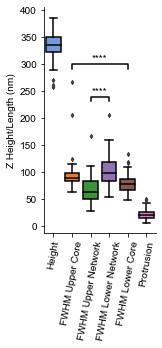

In [97]:
colors = sns.color_palette()
colors = colors[:3] + colors[4:]
colors[0] = 'cornflowerblue'

quant = np.hstack([pod_height,fwhm_upper_core,fwhm_upper_net,fwhm_lower_net,fwhm_lower_core,protrusion_below_net])
meas = np.hstack([['Height']*len(pod_height),['FWHM Upper Core']*len(fwhm_upper_core),
                  ['FWHM Upper Network']*len(fwhm_upper_net),['FWHM Lower Network']*len(fwhm_lower_net),
                  ['FWHM Lower Core']*len(fwhm_lower_core),['Protrusion']*len(protrusion_below_net)])

quant_df = pd.DataFrame(list(zip(quant,meas)),columns = ['Quantification','Measure'])

df = quant_df
x = 'Measure'
y = 'Quantification'
box_pairs=[
    ("FWHM Upper Core", "FWHM Lower Core"),
    ("FWHM Upper Network", "FWHM Lower Network"),
    ]

fig = plt.figure(figsize=(2.,4.15))

flierprops = dict(marker='d', markersize=3)

ax = sns.boxplot(x=x, y=y,data=df,showfliers=True,palette=colors,flierprops=flierprops)
# sns.stripplot(x=x, y=y,  data=df,color=".2",alpha=0.5)
add_stat_annotation(ax, data=df, x=x, y=y, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2)


ax = plt.gca()
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    # iterate over whiskers and median lines
    for j in range(6*6+2): #range(6*i,6*(i+1)):
        ax.lines[j].set_color('black')
        
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

            
plt.xlabel('')
plt.xticks(rotation=80)
plt.ylabel('Z Height/Length (nm)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


adjust_box_widths(fig, 0.98)

# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure5_PodosomeQuantifications/IndividualPlots/IndQuantHeightLength.pdf",transparent=True,dpi=300,bbox_inches='tight')

# plt.tight_layout()

In [177]:
for meas in quant_df['Measure'].unique():
    print(meas, sum(quant_df['Measure']==meas))

Height 72
FWHM Upper Core 72
FWHM Upper Network 61
FWHM Lower Network 64
FWHM Lower Core 48
Protrusion 64


In [98]:
for meas in quant_df['Measure'].unique():
    print(meas, quant_df[quant_df['Measure']==meas].mean(),quant_df[quant_df['Measure']==meas].std())

Height Quantification    334.439822
dtype: float64 Quantification    24.066458
dtype: float64
FWHM Upper Core Quantification    93.244912
dtype: float64 Quantification    27.947305
dtype: float64
FWHM Upper Network Quantification    65.917513
dtype: float64 Quantification    23.68076
dtype: float64
FWHM Lower Network Quantification    103.446369
dtype: float64 Quantification    28.595096
dtype: float64
FWHM Lower Core Quantification    78.425926
dtype: float64 Quantification    18.093885
dtype: float64
Protrusion Quantification    21.085255
dtype: float64 Quantification    10.083119
dtype: float64


#### Get heatmaps from performing "perpendicular line scan"

In [103]:
all_scans_in = []
all_scans_out = []


for i,image_stack in enumerate(image_stacks):
    scans_in = []
    scans_out = []
    scans_along = []
    # plt.figure()
    for j,image in enumerate(image_stack[0]):

        actin=image
        
        
        clusters = all_clusters[i]
        centers = all_centers[i]
        
        
        pix_size=pix_sizes[i]
        dist_um = 0.6
        out_actin, in_actin = out_in_scans_from_pods(actin,centers,clusters,pix_size,dist_um)

        scans_in.append(in_actin)
        scans_out.append(out_actin)

    all_scans_in.append(scans_in)
    all_scans_out.append(scans_out)


#### Process line scan stacks

In [104]:
lowest_max_height_ind = 45

all_scans_in = [all_scans_in[i][:lowest_max_height_ind] for i in range(len(all_scans_in))]
all_scans_out = [all_scans_out[i][:lowest_max_height_ind] for i in range(len(all_scans_out))]

all_scans_in_stack = np.hstack(all_scans_in)
all_scans_out_stack = np.hstack(all_scans_out)


#### Plot perpendicular line scan heatmaps with respective radial averaging heatmaps

In [106]:

def align_axis_y(ax, ax_target):
    """Make y-axis of `ax` aligned with `ax_target` in figure"""
    posn_old, posn_target = ax.get_position(), ax_target.get_position()
    ax.set_position([posn_old.x0, posn_target.y0, posn_old.width, posn_target.height])

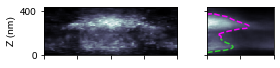

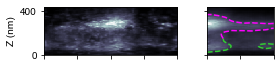

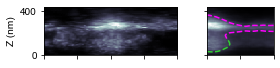

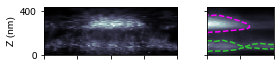

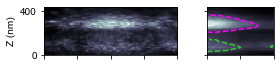

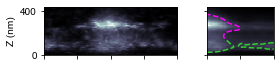

In [107]:
# pp = PdfPages('../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/AllRadAndLS.pdf')

pods = [0,10,22,48,50,66]

for pod_i in pods:

    in_mean = all_scans_in_stack[:,pod_i,:]
    out_mean =all_scans_out_stack[:,pod_i,:]
    out_in = np.hstack([in_mean.T[:-1][::-1].T,out_mean]) #reverse in and exclude measurement at r0 (same for out)



    PROPS = {
        'boxprops':{'edgecolor':'black'},
        'medianprops':{'color':'black'},
        'whiskerprops':{'color':'black'},
        'capprops':{'color':'black'}
    }

    f, (ax_2, ax_1) = plt.subplots(1,2, sharey=True,gridspec_kw={'width_ratios': [2/3,1/3]},figsize=(4,1.5))
#     plt.suptitle('Pod. #%i' %pod_i)

    average_radial = np.array(stack_all_rad_scans)[:,pod_i,:] 
    average_radial = max_min_scaled(average_radial)

    # Used for the contour
    average_radial_smoothed = max_min_scaled(scpy.ndimage.gaussian_filter(average_radial ,1))

    # Get contour threshold 
    # Value used is the mean intensity within 350 nm radius
    contour_level = np.mean(average_radial_smoothed[:].T[:36]) 

    # Get meshgrid for contour
    x = np.linspace(0, max_r, len(average_radial[0]))
    y = np.linspace(150, 10*(len(average_radial)-1), len(average_radial[16:]))
    X, Y = np.meshgrid(x, y)

    im1 = ax_1.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.bone)

    CS = ax_1.contour(X,Y,average_radial_smoothed[16:],levels=np.array([contour_level]), colors='magenta', linestyles='--',linewidth=0.5)
    

    ax_1.set_yticks([0,400])
    ax_2.set_ylabel('Z (nm)') #''Height Z (nm) ')
    # ax_1.set_title('Rad. Avg.')
    # ax_2.set_ylabel('Height Z (nm)')
    
    # Zoom in an observe contour below 100 nm Z
    average_radial_zoomed = average_radial_smoothed[:16] #scpy.ndimage.gaussian_filter(average_radial_mirrored[:15],1)
    average_radial_zoomed_smoothed = average_radial_smoothed[:16]
    x = np.linspace(0, max_r, len(average_radial_zoomed[0]))
    y = np.linspace(0, 10*(len(average_radial_zoomed)-1), len(average_radial_zoomed))
    X, Y = np.meshgrid(x, y)

    CS = ax_1.contour(X,Y,average_radial_zoomed_smoothed,levels=np.array([contour_level]), colors='limegreen', linestyles='--',linewidth=0.5)


    im3 = ax_2.imshow(max_min_scaled(out_in),extent=[-max_r,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.bone)
    # plt.colorbar(fraction=0.025, pad=0.04)
    # ax_2.set_title('Perp. LS')
    
    if pod_i == 68:
        pass
#         ax_1.set_xlabel('Radius R (nm)')
#         ax_2.set_xlabel('Distance D (nm)')
    else:
        ax_1.set_xticks([0,300,600])
        ax_2.set_xticks([-600,-300,0,300,600])
        ax_1.set_xticklabels([])
        ax_2.set_xticklabels([])

    # ax_2.set_yticks([0,400])
    plt.tight_layout()


#     divider = make_axes_locatable(ax_1)
#     cax = divider.append_axes("right", size="7.5%", pad=0.05)
#     plt.colorbar(im3, cax=cax)
    


    # plt.tight_layout()


    plt.subplots_adjust(wspace=0.3, hspace=1.)

#     pp.savefig(f,bbox_inches ='tight')
# 
#     plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/IndRadAndLSPod_flip%i.pdf"%pod_i,transparent=True,bbox_inches = "tight",dpi=300)
# pp.close()


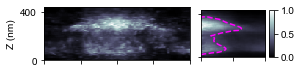

In [108]:
# pp = PdfPages('../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/AllRadAndLS.pdf')


# pod_i = 28 #28
pods = [0,10,22,48,50,66]

for pod_i in [0]:

    in_mean = all_scans_in_stack[:,pod_i,:]
    out_mean =all_scans_out_stack[:,pod_i,:]
    out_in = np.hstack([in_mean.T[:-1][::-1].T,out_mean]) #reverse in and exclude measurement at r0 (same for out)



    PROPS = {
        'boxprops':{'edgecolor':'black'},
        'medianprops':{'color':'black'},
        'whiskerprops':{'color':'black'},
        'capprops':{'color':'black'}
    }

    f, (ax_2, ax_1) = plt.subplots(1,2, sharey=True,gridspec_kw={'width_ratios': [2/3,1/3]},figsize=(4,1.5))
#     plt.suptitle('Pod. #%i' %pod_i)

    average_radial = np.array(stack_all_rad_scans)[:,pod_i,:] 
    average_radial = max_min_scaled(average_radial)

    # Used for the contour
    average_radial_smoothed = max_min_scaled(scpy.ndimage.gaussian_filter(average_radial ,1))

    # Get contour threshold 
    # Value used is the mean intensity within 350 nm radius
    contour_level = np.mean(average_radial_smoothed[:].T[:36]) 

    # Get meshgrid for contour
    x = np.linspace(0, max_r, len(average_radial[0]))
    y = np.linspace(0, 10*(len(average_radial)-1), len(average_radial))
    X, Y = np.meshgrid(x, y)

    im1 = ax_1.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.bone)

    CS = ax_1.contour(X,Y,average_radial_smoothed,levels=np.array([contour_level]), colors='magenta', linestyles='--',linewidth=0.5)
    

    ax_1.set_yticks([0,400])
    ax_2.set_ylabel('Z (nm)') #''Height Z (nm) ')
    # ax_1.set_title('Rad. Avg.')
    # ax_2.set_ylabel('Height Z (nm)')

    im3 = ax_2.imshow(max_min_scaled(out_in),extent=[-max_r,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.bone)
    # plt.colorbar(fraction=0.025, pad=0.04)
    # ax_2.set_title('Perp. LS')
    
    if pod_i == 68:
        pass
#         ax_1.set_xlabel('Radius R (nm)')
#         ax_2.set_xlabel('Distance D (nm)')
    else:
        ax_1.set_xticks([0,300,600])
        ax_2.set_xticks([-600,-300,0,300,600])
        ax_1.set_xticklabels([])
        ax_2.set_xticklabels([])

    # ax_2.set_yticks([0,400])
    plt.tight_layout()


    divider = make_axes_locatable(ax_1)
    cax = divider.append_axes("right", size="7.5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    


    # plt.tight_layout()


    plt.subplots_adjust(wspace=0.1, hspace=1.)

#     pp.savefig(f,bbox_inches ='tight')
# 
#     plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/IndRadAndLSPod_CB_ref.pdf",transparent=True,bbox_inches = "tight",dpi=300)
# pp.close()


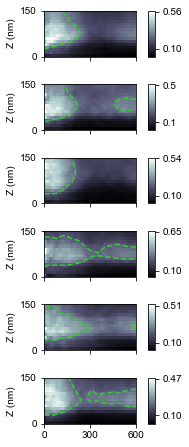

In [109]:
# pp = PdfPages('../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/AllRadAndLS.pdf')

pods = [0,10,22,48,50,66]

plt.figure(figsize=(3.,7.6))
for i,pod_i in enumerate(pods):

#     in_mean = all_scans_in_stack[:,pod_i,:]
#     out_mean =all_scans_out_stack[:,pod_i,:]
#     out_in = np.hstack([in_mean.T[:-1][::-1].T,out_mean]) #reverse in and exclude measurement at r0 (same for out)



    PROPS = {
        'boxprops':{'edgecolor':'black'},
        'medianprops':{'color':'black'},
        'whiskerprops':{'color':'black'},
        'capprops':{'color':'black'}
    }

    plt.subplot(6,1,i+1)
#     plt.suptitle('Pod. #%i' %pod_i)

    average_radial = np.array(stack_all_rad_scans)[:,pod_i,:] 
    average_radial = max_min_scaled(average_radial)

    average_radial_smoothed = max_min_scaled(scpy.ndimage.gaussian_filter(average_radial ,1))

    # Get contour threshold 
    # Value used is the mean intensity within 350 nm radius
    contour_level = np.mean(average_radial_smoothed[:].T[:36]) 
    
    # Zoom in an observe contour below 150 nm Z
    average_radial_zoomed = average_radial[:16] #scpy.ndimage.gaussian_filter(average_radial_mirrored[:15],1)
    average_radial_zoomed_smoothed = average_radial_smoothed[:16]
    x = np.linspace(0, max_r, len(average_radial_zoomed[0]))
    y = np.linspace(0, 10*(len(average_radial_zoomed)-1), len(average_radial_zoomed))
    X, Y = np.meshgrid(x, y)

    
    plt.ylabel('Z (nm)')
#     plt.xlabel('R (nm)')
    plt.xticks([0,300,600])
    plt.yticks([0,150])
    
    if pod_i !=66:
        plt.xticks([0,300,600],labels=[])
    ax = plt.gca()

    
    im = plt.imshow(average_radial_zoomed,extent=[0,max_r,0,10*(len(average_radial_zoomed)-1)],aspect=2,origin='lower',interpolation='none',cmap=plt.cm.bone)
    CS = plt.contour(X,Y,average_radial_zoomed_smoothed,levels=np.array([contour_level]), colors='limegreen', linestyles='--',linewidth=0.5)
    


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=-0.47)
    plt.colorbar(im, cax=cax,ticks=[0.1,np.round(np.max(average_radial_zoomed)-0.01,2)])

    # plt.tight_layout()

    plt.subplots_adjust(wspace=0.1, hspace=0.6)
#     plt.tight_layout()
#     pp.savefig(f,bbox_inches ='tight')

#     plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/IndProtrusions_Subset.pdf",transparent=True,bbox_inches = "tight",dpi=300)
# pp.close()


In [116]:
# # Set rows of 0s to nans - don't want to include values outside the image in the mean

# all_scans_out_stack_nan = np.array(all_scans_out_stack,dtype=float)

# for i in range(np.shape(all_scans_out_stack_nan)[1]):
#     nan_col = np.mean(all_scans_out_stack_nan[:,i,:],axis=0) == 0

#     if np.sum(nan_col) > 0 :
#         all_scans_out_stack_nan[:,i,:].T[nan_col] = np.nan

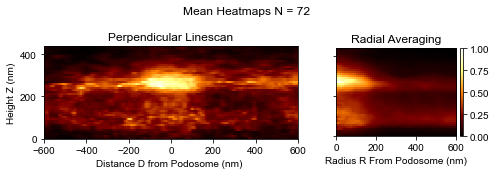

In [117]:
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

f, (ax_2, ax_1) = plt.subplots(1,2, sharey=True,gridspec_kw={'width_ratios': [2/3,1/3]},figsize=(7,3))
f.subplots_adjust(top=0.8)
plt.suptitle('Mean Heatmaps N = %i ' %(np.shape(all_rad)[1]),y=0.85)

im1 = ax_1.imshow(average_radial,extent=[0,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.afmhot)

ax_1.set_title('Radial Averaging')
ax_2.set_ylabel('Height Z (nm)')
ax_1.set_xlabel('Radius R From Podosome (nm)')

im2 = ax_2.imshow(max_min_scaled(out_in),extent=[-max_r,max_r,0,np.max(heights)],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.afmhot)
# plt.colorbar(fraction=0.025, pad=0.04)
ax_2.set_title('Perpendicular Linescan')
# ax_2.set_ylabel('Height Z (nm)')
ax_2.set_xlabel('Distance D from Podosome (nm) ')


divider = make_axes_locatable(ax_1)
cax = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(im2, cax=cax)

plt.tight_layout()

plt.subplots_adjust(wspace=0.2, hspace=1.)

# plt.savefig("../../../SH-CH/WorkingFiguresCurrent/Figure3_Heatmaps/IndividualPlots/AverageRadAndLS_flip.pdf",transparent=True,bbox_inches = "tight",dpi=300)
